In [1]:
import tensorflow as tf

import cv2
import numpy as np 
from matplotlib import pyplot as plt

import glob
import os 

import imgaug as ia
from imgaug import augmenters as iaa
import efficientnet.tfkeras as enet

In [2]:
batch_size = 32
input_shape = (224, 224, 3)
learning_rate = 1e-4
epochs = 20

In [3]:
label_map = {
    'buildings': 0,
    'forest': 1,
    'glacier': 2,
    'mountain': 3,
    'sea': 4,
    'street': 5
}

# Build model
- Using resnet152 as a backbone transfer learning
- Using efficientb3 as a backbone check performance in comparison to resent152

In [4]:
resnet_backbone = tf.keras.applications.ResNet152V2(
    weights='imagenet', include_top=False,
    input_shape=input_shape
)

In [5]:
for layer in resnet_backbone.layers[:-15]:
    layer.trainable = False

In [6]:
def get_renset_model(n_classes=6):
    x = resnet_backbone.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    output = tf.keras.layers.Dense(n_classes, activation='softmax')(x)
    
    return tf.keras.Model(resnet_backbone.input, output)

In [4]:
# EffNET
#Define swish here
from tensorflow.keras.backend import sigmoid
from tensorflow.keras.layers import Activation
from tensorflow.keras.utils import get_custom_objects

class SwishActivation(Activation):
    def __init__(self, activation, **kwargs):
        super(SwishActivation, self).__init__(activation, **kwargs)
        self.__name__ = 'swish_act'
        
def swish_act(x, beta=1):
    return (x * sigmoid(beta * x))

get_custom_objects().update({'swish_act': SwishActivation(swish_act)})

In [35]:
def get_effnet(input_shape, n_classes=6):
    model = enet.EfficientNetB5(
        include_top=False, input_shape=input_shape,
        pooling='avg', weights='imagenet'
    )
    
    x = model.output
    
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.7)(x)
    
    x = tf.keras.layers.Dense(512)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(swish_act)(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    
    x = tf.keras.layers.Dense(128)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(swish_act)(x)
    
    output = tf.keras.layers.Dense(n_classes, activation='softmax')(x)
    
    return tf.keras.models.Model(inputs=model.input, outputs=output)

# Prepare data and set generator

In [18]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(
        self, samples, batch_size=32, 
        input_shape=(150, 150), n_channels=3, n_classes=6, 
        shuffle=True, augment=False
    ):
        self.samples = samples
        self.input_shape = input_shape
        self.batch_size = batch_size
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.augment = augment
        self.on_epoch_end()
        self.classes = [s[1] for s in self.samples]
        
    def __len__(self):
        return int(np.floor(len(self.samples) / self.batch_size))
    
    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size: (index + 1) * self.batch_size]
        batch_samples = [self.samples[k] for k in indexes]
        
        # Generate data
        X, y = self.data_generator(batch_samples)
        
        return X, y
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.samples))
        if self.shuffle:
            np.random.shuffle(self.indexes)
            
    def data_generator(self, batch_samples):
        X = np.empty((self.batch_size, *self.input_shape, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)
        
        # Generate data
        for i, batch_sample in enumerate(batch_samples):
            image_path = batch_sample[0]
            label = batch_sample[1]
            
            img = cv2.imread(image_path)
            img = cv2.resize(img, self.input_shape)
            img = img / 255

            X[i, ] = img
            y[i] = label
        
        if self.augment:
            X = self.augmentor(X)
            
        return X , tf.keras.utils.to_categorical(y, num_classes=self.n_classes)
    
    def augmentor(self, images):
        'Apply data augmentation'
        sometimes = lambda aug: iaa.Sometimes(0.5, aug)

        seq = iaa.Sequential([
            iaa.Fliplr(0.5),
            iaa.Flipud(0.3),
            sometimes(iaa.Affine(
                scale={'x': (0.8, 1.2), 'y': (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
                translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # translate by -20 to +20 percent (per axis)
                rotate=(-45, 45),
                shear=(-16, 16),
                order=[0, 1],
                cval=(0, 255),
                mode=ia.ALL
            )),
#             sometimes(iaa.CropAndPad(
#                 percent=(-0.05, 0.1),
#                 pad_mode=ia.ALL,
#                 pad_cval=(0, 255)
#             )),
#             iaa.SomeOf((0, 5), [
#                 # Run one of the following
#                 iaa.OneOf([
#                     iaa.GaussianBlur((0, 3.0)),
#                     iaa.AverageBlur(k=(2, 7)),
#                     iaa.MedianBlur(k=(3, 11))
#                 ]),
#                 iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)),
#                 iaa.OneOf([
#                     iaa.Multiply((0.5 , 1.5), per_channel=0.5),
#                     iaa.FrequencyNoiseAlpha(
#                         exponent=(-4, 0),
#                         first=iaa.Multiply((0.5, 1.5), per_channel=True),
#                         second=iaa.LinearContrast((0.5, 2.0))
#                     )
#                 ])
#             ], random_order=True)
        ], random_order=True)
        
        
        return seq(images=images)

In [10]:
def load_samples(image_dir):
    images_dir = glob.glob(image_dir + '*/*.jpg')
    samples = []
    
    for image_dir in images_dir:
        label = os.path.basename(os.path.dirname(image_dir))
        samples.append([
            image_dir, label_map[label]
        ])
    
    return samples

In [11]:
train_samples = load_samples('data/seg_train/seg_train/')
test_samples = load_samples('data/seg_test/seg_test/')

In [12]:
train_generator = DataGenerator(
    train_samples, batch_size=batch_size, input_shape=(224, 224), n_classes=6, augment=True
)

test_generator = DataGenerator(
    test_samples, batch_size=batch_size, input_shape=(224, 224), n_classes=6
)

# Compile and train model

In [12]:
# model = get_renset_model()
model = get_effnet(input_shape)

In [13]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 40) 1080        input_2[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 40) 160         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 40) 0           stem_bn[0][0]                    
____________________________________________________________________________________________

In [37]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy', 
    patience=3, 
    verbose=1, 
    factor=0.4, 
    min_lr=0.0001
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0,
    patience=2,
    verbose=1,
    mode='auto'
)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'weights/effnet_b5_weights.h5', 
    monitor='val_accuracy', 
    verbose=1,
    save_best_only=True,
    mode='max'
)

history = model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_samples) // batch_size,
    validation_data=test_generator,
    validation_steps=len(test_samples) // batch_size,
    epochs=epochs,
    callbacks=[early_stopping, reduce_lr, model_checkpoint]
)

Epoch 1/20
438/438 [==============================] - ETA: 0s - loss: 0.2978 - accuracy: 0.8983
Epoch 00001: val_accuracy improved from -inf to 0.89852, saving model to weights/effnet_b5_weights.h5
438/438 [==============================] - 220s 503ms/step - loss: 0.2978 - accuracy: 0.8983 - val_loss: 0.2728 - val_accuracy: 0.8985 - lr: 1.0000e-04
Epoch 2/20
438/438 [==============================] - ETA: 0s - loss: 0.2748 - accuracy: 0.9058
Epoch 00002: val_accuracy improved from 0.89852 to 0.90020, saving model to weights/effnet_b5_weights.h5
438/438 [==============================] - 220s 503ms/step - loss: 0.2748 - accuracy: 0.9058 - val_loss: 0.2635 - val_accuracy: 0.9002 - lr: 1.0000e-04
Epoch 3/20
438/438 [==============================] - ETA: 0s - loss: 0.2632 - accuracy: 0.9080
Epoch 00003: val_accuracy improved from 0.90020 to 0.90222, saving model to weights/effnet_b5_weights.h5
438/438 [==============================] - 223s 510ms/step - loss: 0.2632 - accuracy: 0.9080 - v

In [38]:
model.evaluate(test_generator)

93/93 [==============================] - 9s 95ms/step - loss: 0.2318 - accuracy: 0.9177


[0.23175708949565887, 0.917674720287323]

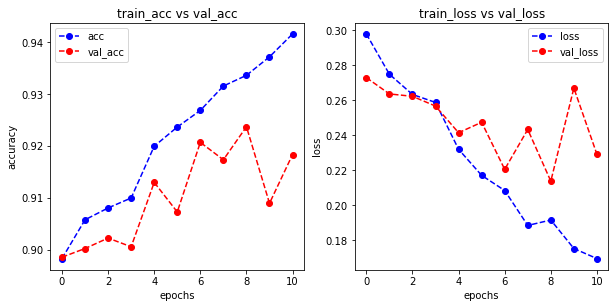

In [39]:
# Lets plot the history
plt.figure(figsize=(10, 10))

plt.subplot(221)
plt.plot(history.history['accuracy'], 'bo--', label='acc')
plt.plot(history.history['val_accuracy'], 'ro--', label='val_acc')
plt.title("train_acc vs val_acc")
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.legend()

plt.subplot(222)
plt.plot(history.history['loss'], 'bo--', label='loss')
plt.plot(history.history['val_loss'], 'ro--', label='val_loss')
plt.title("train_loss vs val_loss")
plt.ylabel("loss")
plt.xlabel("epochs")

plt.legend()
plt.show()

In [40]:
pred_images = glob.glob('data/seg_pred/seg_pred/*.jpg')
# labels = [os.path.basename(folders) for folders in glob.glob('data/seg_train/seg_train/*')]
labels = list(label_map.keys())

In [ ]:
# prepare image for inference
np.random.shuffle(pred_images)

row = 6
column = 5
count = 0
plt.figure(figsize=(15, 15))

for pred_image in pred_images:
    img = cv2.imread(pred_image)
    img_copy = img.copy()
    img_copy = cv2.resize(img, (224, 224))
    img_copy = img_copy / 255
    img_copy = np.expand_dims(img_copy, axis=0)

    preds = model.predict(img_copy)

    pred_max = np.argmax(preds)
    
    count += 1
    plt.subplot(row, column, count)
    
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(labels[pred_max])
    plt.tight_layout()
    if count == row * column:
        break

# Evaluation

In [6]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.metrics import roc_auc_score
import seaborn as sns

In [7]:
model = tf.keras.models.load_model('weights/effnet_weights.h5')

In [23]:
labels = list(label_map.keys())

Y_pred = model.predict_generator(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

In [24]:
cm = confusion_matrix(test_generator.classes[:2976], y_pred)

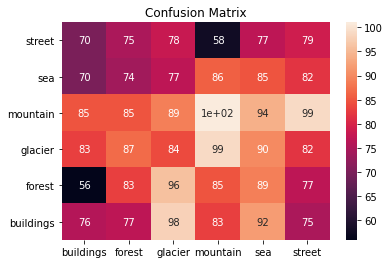

In [25]:
ax = plt.subplot()
ax.set_title('Confusion Matrix'); 
sns.heatmap(cm, annot=True, ax=ax, xticklabels=labels, yticklabels=labels[::-1])

In [26]:
TN = cm[0][0]
FN = cm[1][0]
TP = cm[1][1]
FP = cm[0][1]

TP, FP, FN, TN

(74, 75, 70, 70)

In [27]:
print(classification_report(test_generator.classes[:2976], y_pred, target_names=labels))

              precision    recall  f1-score   support

   buildings       0.16      0.16      0.16       437
      forest       0.15      0.16      0.15       474
     glacier       0.17      0.16      0.17       553
    mountain       0.19      0.19      0.19       525
         sea       0.17      0.18      0.18       486
      street       0.15      0.15      0.15       501

    accuracy                           0.17      2976
   macro avg       0.17      0.17      0.17      2976
weighted avg       0.17      0.17      0.17      2976

